In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, mean_absolute_error, mean_squared_error

In [2]:
df_cls = pd.read_csv("classification_dataset.csv")
df_reg = pd.read_csv("regression_dataset.csv")

def split_Xy(df):
    cand = [c for c in df.columns if c.lower() in ("y","label","target")]
    ycol = cand[0] if cand else df.columns[-1]
    xcols = [c for c in df.columns if c != ycol]
    X = df[xcols].to_numpy(float)
    y = df[ycol].to_numpy(float)
    return X, y, xcols, ycol

Xc, yc, xcols_c, ycol_c = split_Xy(df_cls)
Xr, yr, xcols_r, ycol_r = split_Xy(df_reg)

Xc_tr, Xc_te, yc_tr, yc_te = train_test_split(Xc, yc, test_size=0.25, random_state=42, stratify=yc)
Xr_tr, Xr_te, yr_tr, yr_te = train_test_split(Xr, yr, test_size=0.25, random_state=42)



In [3]:
C = RandomForestClassifier(n_estimators=400, min_samples_leaf=5, random_state=42)
C.fit(Xc_tr, yc_tr)

R = RandomForestRegressor(n_estimators=500, min_samples_leaf=5, random_state=42)
R.fit(Xr_tr, yr_tr)

print(f"[C] acc={accuracy_score(yc_te, C.predict(Xc_te)):.3f}")

# ==== h(x) ====
def h(X, C_model, R_model, invalid_value=-999):
    X2 = np.atleast_2d(X)
    c = C_model.predict(X2).ravel()
    out = np.full(X2.shape[0], invalid_value, dtype=float)
    idx = (c == 1)
    if idx.any():
        out[idx] = R_model.predict(X2[idx])
    return out if X2.shape[0] > 1 else out[0]

y_h = h(Xr_te, C, R, invalid_value=-999)
mask_valid = (y_h != -999)

[C] acc=0.987


In [4]:
if mask_valid.any():
    mae = mean_absolute_error(yr_te[mask_valid], y_h[mask_valid])
    rmse = np.sqrt(mean_squared_error(yr_te[mask_valid], y_h[mask_valid]))
    print(f"[h(x)] on valid region: MAE={mae:.3f}, RMSE={rmse:.3f}, count={mask_valid.sum()}")


[h(x)] on valid region: MAE=1.748, RMSE=2.604, count=869


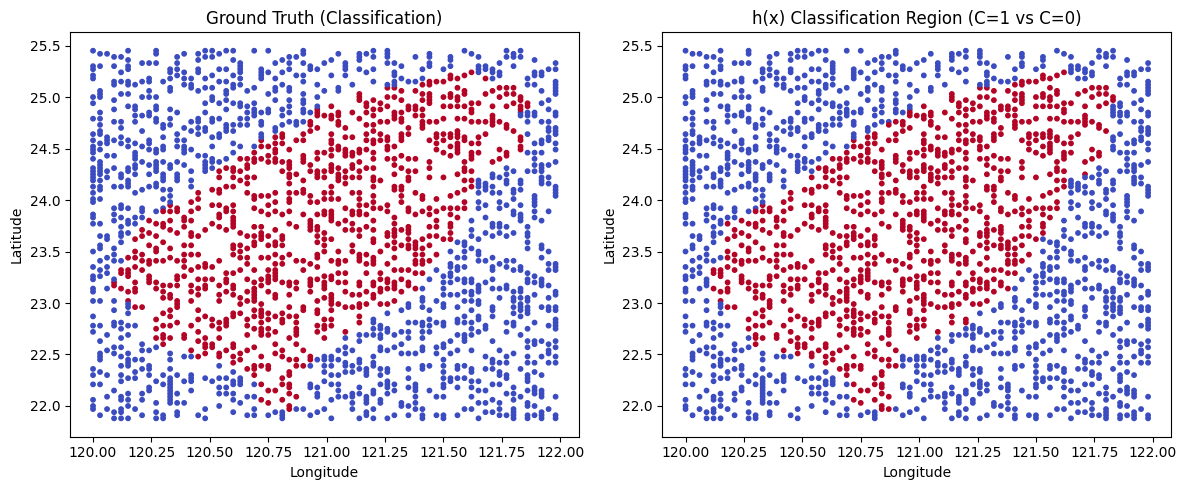

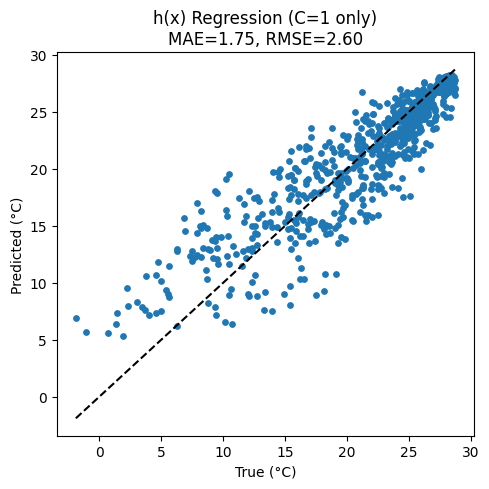

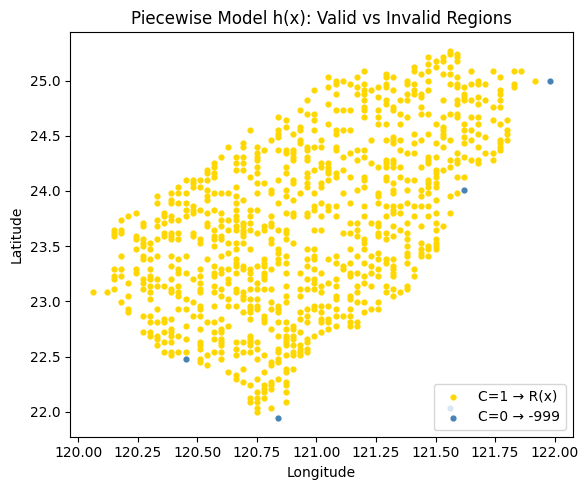

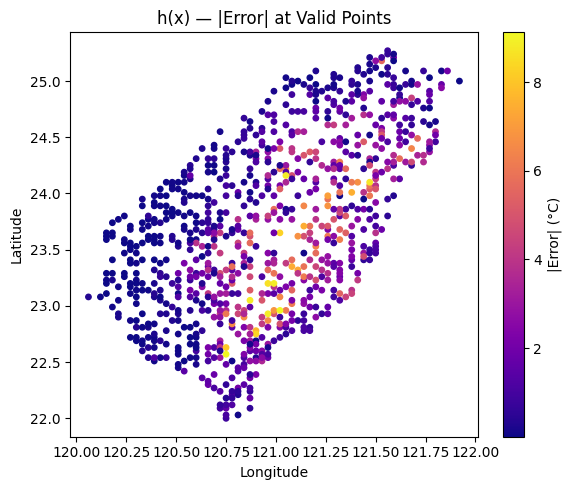

In [5]:
### Visualization

lon, lat = Xr_te[:,0], Xr_te[:,1]

# 1. 分類結果
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(Xc_te[:,0], Xc_te[:,1], c=yc_te, cmap="coolwarm", s=10)
plt.title("Ground Truth (Classification)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")

plt.subplot(1,2,2)
plt.scatter(Xc_te[:,0], Xc_te[:,1], c=C.predict(Xc_te), cmap="coolwarm", s=10)
plt.title("h(x) Classification Region (C=1 vs C=0)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.tight_layout()
plt.show()

# 2. 回歸真實 vs h(x) 預測值
if mask_valid.any():
    plt.figure(figsize=(5,5))
    plt.scatter(yr_te[mask_valid], y_h[mask_valid], s=15)
    lims = [min(yr_te.min(), y_h[mask_valid].min()), max(yr_te.max(), y_h[mask_valid].max())]
    plt.plot(lims, lims, 'k--')
    plt.title(f"h(x) Regression (C=1 only)\nMAE={mae:.2f}, RMSE={rmse:.2f}")
    plt.xlabel("True (°C)"); plt.ylabel("Predicted (°C)")
    plt.tight_layout()
    plt.show()

# 3. h(x) 預測分布圖
plt.figure(figsize=(6,5))
mask_valid = (y_h != -999)

# 有效區域 (C=1)
plt.scatter(Xr_te[mask_valid,0], Xr_te[mask_valid,1],
            color='gold', s=12, label='C=1 → R(x)')

# 無效區域 (C=0)
plt.scatter(Xr_te[~mask_valid,0], Xr_te[~mask_valid,1],
            color='steelblue', s=12, label='C=0 → -999')

plt.title("Piecewise Model h(x): Valid vs Invalid Regions")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# 4. 誤差地圖（僅有效區域）
if mask_valid.any():
    err = np.abs(y_h[mask_valid] - yr_te[mask_valid])
    plt.figure(figsize=(6,5))
    sc = plt.scatter(lon[mask_valid], lat[mask_valid], c=err, cmap="plasma", s=15)
    plt.colorbar(sc, label="|Error| (°C)")
    plt.title("h(x) — |Error| at Valid Points")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.tight_layout()
    plt.show()

※為了確認程式能完整執行，本檔案在最終提交前重新執行（重跑）一次。由於模型訓練過程包含隨機初始化與資料抽樣，最終的訓練與測試結果可能與先前版本略有不同，但不影響整體結論與分析方向。